**Welcome to the Jupyter notebook example showing programmatically discovery and accesso of WHOS data**

This notebook is used to programmatically access WHOS DAB functionalities, in this case through the OGC OM-JSON based API, documented and available for tests also here: https://whos.geodab.eu/gs-service/om-api

As a prerequisite to obtain programmatically access to WHOS, a token is required. It can be obtained after WHOS user registration here: https://community.wmo.int/en/whos-web-services-and-supported-tools

The first example uses the whos-sensorthingshydro2 view, to obtain records on the HydroServer instance prepared for the workshop where participants can upload their datasets.

The following test portal can also be used to help debug your python notebook: https://whos.geodab.eu/gs-service/search?view=whos-sensorthingshydro2

A series of constraints can be used (e.g. bounding box, temporal extent, observed property, ...) to discover the data. Then it can be accessed and visualized.

In [1]:
import urllib.parse
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import userdata

token = userdata.get('token-his-central')
view = 'whos'
#baseURL = 'http://whos.geodab.eu/gs-service/services/essi/token/'
#baseURL = 'http://gs-service-preproduction.geodab.eu/gs-service/services/essi/token/'
#baseURL = 'http://boldrini.essi-lab.eu:9090/gs-service/services/essi/token/'
baseURL = 'https://his-central.geodab.eu/gs-service/services/essi/token/'



In [2]:
def obfuscate_token(text, token):
    """
    Replaces the token in the given string with '***'.

    Parameters:
        text (str): The string containing the token to obfuscate.
        token (str): The token to obfuscate.

    Returns:
        str: The string with the token replaced by '***'.
    """
    return text.replace(token, "***")

In [3]:
# clear constraints
bbox = ""
temporal = ""
observedProperty = ""
ontology = ""

In [4]:
# Algeria example
south = 35.066
west = -1.296
north = 37.466
east = 4.581

view = 'his-central'
bbox = "&west="+str(west)+"&south="+str(south)+"&east="+str(east)+"&north="+str(north)

In [16]:
# Tuscany example
south = 42.425
west = 9.844
north = 43.981
east = 11.625

view = 'his-central'
bbox = "&west="+str(west)+"&south="+str(south)+"&east="+str(east)+"&north="+str(north)

In [18]:
# observed property
observedProperty = "&observedProperty="+urllib.parse.quote("Flux, discharge")
ontology="&ontology=his-central"

In [19]:
# observed property
observedProperty = "&observedProperty="+urllib.parse.quote("http://hydro.geodab.eu/hydro-ontology/concept/76")
ontology="&ontology=his-central"

In [21]:
# observed property
observedProperty = "&observedProperty="+urllib.parse.quote("temperatura")
ontology="&ontology=his-central"

First we search for stations

In [23]:
import requests
server = baseURL + token + '/view/' + view + '/om-api/'
url = server+"features?"+observedProperty+ontology+bbox
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)

if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    sites = []
    if 'results' not in data:
        print("No results found")
    else:
      for site in data['results']:

          coordinates = site['shape']['coordinates']
          source = next(param['value'] for param in site['parameter'] if param['name'] == 'source')
          identifier = next(param['value'] for param in site['parameter'] if param['name'] == 'identifier')
          name = site['name']
          site_id = site['id']
          if 'relatedParty' in site and site['relatedParty']: # Add this check
            contact_name = site['relatedParty'][0].get('individualName',None)
            contact_email = site['relatedParty'][0].get('electronicMailAddress',None)
          else:
            contact_name = ""
            contact_email = ""


          sites.append({
              'Name': name,
              'ID': site_id,
              'Coordinates': f"{coordinates[0]}, {coordinates[1]}",
              'Source': source,
              'Identifier': identifier,
              'Contact Name': contact_name,
              'Contact Email': contact_email
          })

      # Create a DataFrame for tabular display
      df = pd.DataFrame(sites)

      styled_df = df.style.set_properties(**{
          'text-align': 'left',  # Align text to the left
          'border': '1px solid black',  # Add borders
          'padding': '5px'  # Add padding
      }).set_table_styles([
          {"selector": "th", "props": [("text-align", "left")]}
      ])

      # Display the table
      display(styled_df)

else:
    print("HTTP GET request failed with status code:", response.status_code)

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/features?&observedProperty=temperatura&ontology=his-central&west=9.844&south=42.425&east=11.625&north=43.981


,Name,ID,Coordinates,Source,Identifier,Contact Name,Contact Email
0,Sorana,009C8A33B864A1A7B8072B3DA536475A82A1EB24,"10.7163905029729, 43.9690941535097","Italy, Sistema Informativo Regionale Toscana",TOS11000091,,
1,Monteboro,00C978EE022392B6F66F782004F3657817AEC5E8,"10.923, 43.6926","Italy, Sistema Informativo Regionale Toscana",TOS11000504,,
2,Follonica,015446E740283D39BDB049E4B65878B63ED20E56,"10.7654, 42.9331","Italy, Sistema Informativo Regionale Toscana",TOS03002459,,
3,Capannoli,0176D33D89C6555801C137622D7AE3BF7C9C59F1,"10.6844192154688, 43.5922849536088","Italy, Sistema Informativo Regionale Toscana",TOS01005131,,
4,S. Donato,0284F7264A8E96556A0F1027F873D7F061F3C8EE,"11.230902671814, 42.5337297442283","Italy, Sistema Informativo Regionale Toscana",TOS10003100,,
5,Orentano,02B105E17079B01180DC37BCCA9F07A2A1F8FA9D,"10.65708205290674, 43.774424813755616","Italy, Sistema Informativo Regionale Toscana",TOS01001889,,
6,Chiesina di Padule,02EB8BD58B920BC8EE8D82D2B9DE4DF7F0F862DC,"10.6248319276, 43.8032176985","Italy, Sistema Informativo Regionale Toscana",TOS10001870,,
7,Monte Serra,04A3B7246A47A4E334B68F3778FAC645FF692484,"10.5544602870941, 43.7470720785504","Italy, Sistema Informativo Regionale Toscana",TOS11000020,,
8,La Rugea II,058CB78F4E3F9BB74D0ED5C55974DF0C48AE4C21,"11.0788513731, 43.8313506613","Italy, Sistema Informativo Regionale Toscana",TOS10001281,,
9,Poggio,05D9C1FBE34DBD81F6F7BB885F507F53FB506402,"10.18246053991485, 42.79035529078439","Italy, Sistema Informativo Regionale Toscana",TOS10003190,,


Then we select a specific feature to list the available observations

In [24]:
# feature of Tuscany

featureId = "04A3B7246A47A4E334B68F3778FAC645FF692484"

In [25]:

url = server+"observations?feature="+featureId+observedProperty+ontology+bbox
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    #print(data)

    observations = []
    for observation in data['member']:
        source = next(param['value'] for param in observation['parameter'] if param['name'] == 'source')
        observed_property_definition = next(param['value'] for param in observation['parameter'] if param['name'] == 'observedPropertyDefinition')
        original_observed_property = next(param['value'] for param in observation['parameter'] if param['name'] == 'originalObservedProperty')
        observed_property = observation['observedProperty']['title']
        phenomenon_time_begin = observation['phenomenonTime']['begin']
        phenomenon_time_end = observation['phenomenonTime']['end']
        feature_of_interest_href = observation['featureOfInterest']['href']
        observation_id = observation['id']
        observation_type = observation['type']
        uom = observation['result']['defaultPointMetadata']['uom']
        interpolation_type = observation['result']['defaultPointMetadata']['interpolationType']['title']

        observations.append({
            'Source': source,
            'Observed Property Definition': observed_property_definition,
            'Original Observed Property': original_observed_property,
            'Observed Property': observed_property,
            'Phenomenon Time Begin': phenomenon_time_begin,
            'Phenomenon Time End': phenomenon_time_end,
            'Feature of Interest Href': feature_of_interest_href,
            'Observation ID': observation_id,
            'Observation Type': observation_type,
            'Unit of Measurement': uom,
            'Interpolation Type': interpolation_type
        })

    # Create a DataFrame for tabular display
    df = pd.DataFrame(observations)

    # Display the table
    display(df)

else:
    print("HTTP GET request failed with status code:", response.status_code)

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/observations?feature=04A3B7246A47A4E334B68F3778FAC645FF692484&observedProperty=temperatura&ontology=his-central&west=9.844&south=42.425&east=11.625&north=43.981


,Source,Observed Property Definition,Original Observed Property,Observed Property,Phenomenon Time Begin,Phenomenon Time End,Feature of Interest Href,Observation ID,Observation Type,Unit of Measurement,Interpolation Type
0,"Italy, Sistema Informativo Regionale Toscana",Temperatura (C),Temperatura,Temperature,1998-03-05T09:00:00Z,2025-07-21T12:45:57Z,04A3B7246A47A4E334B68F3778FAC645FF692484,11DA49DB7A1DE61A886667C09E31F191C9019A67,TimeSeriesObservation,C,Minimum
1,"Italy, Sistema Informativo Regionale Toscana",Temperatura (C),Temperatura,Temperature,1998-03-05T09:00:00Z,2025-07-21T12:45:57Z,04A3B7246A47A4E334B68F3778FAC645FF692484,D715CBE15327977E890FE570D15CD716A074E52E,TimeSeriesObservation,C,Maximum


In [26]:
# Observation of Tuscany
observationId = "D715CBE15327977E890FE570D15CD716A074E52E"
beginPosition="&beginPosition="+urllib.parse.quote("2025-01-01T00:00:00Z")
endPosition="&endPosition="+urllib.parse.quote("2025-02-01T00:00:00Z")

Retrieving https://his-central.geodab.eu/gs-service/services/essi/token/***/view/his-central/om-api/observations?includeData=true&observationIdentifier=D715CBE15327977E890FE570D15CD716A074E52E&beginPosition=2025-01-01T00%3A00%3A00Z&endPosition=2025-02-01T00%3A00%3A00Z


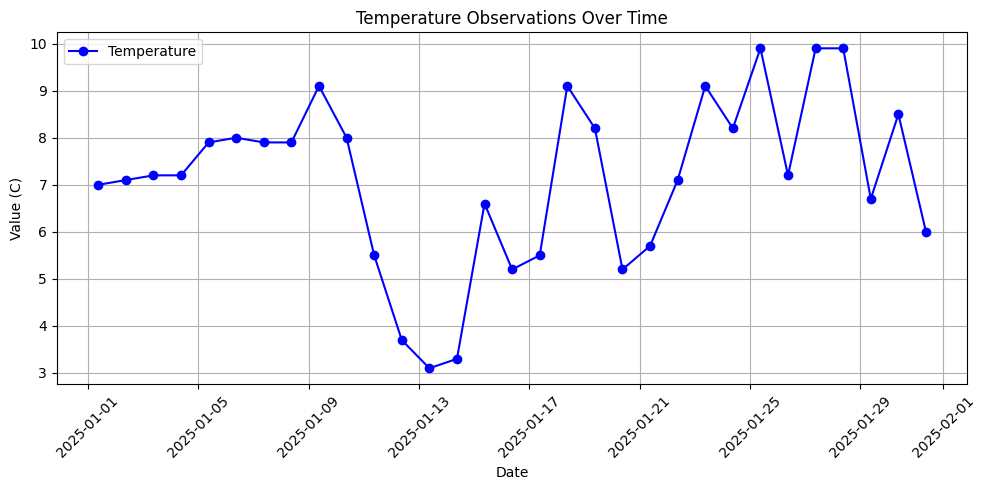

In [31]:
observation="&observationIdentifier="+urllib.parse.quote(observationId)

url = server+"observations?includeData=true"+observation+beginPosition+endPosition
print("Retrieving "+obfuscate_token(url,token))
response = requests.get(url)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    # Extract the points
    points = data['member'][0]['result']['points']

    # Extract time and values
    times = [datetime.fromisoformat(point['time']['instant'].replace("Z", "+00:00")) for point in points]
    values = [point['value'] for point in points]

    # Get feature name and observed property
    # Access the feature_name variable set in the previous cell (7pBbhhLxXkac)
    # The observed_property_name is available in the current data response
    observed_property_name = data['member'][0]['observedProperty']['title']
    unit_of_measurement = data['member'][0]['result']['defaultPointMetadata']['uom']


    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(times, values, marker='o', linestyle='-', color='b', label=observed_property_name)
    plt.title(f'{observed_property_name} Observations Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Value ({unit_of_measurement})')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


else:
    print("HTTP GET request failed with status code:", response.status_code)